* predecessor notebook: http://localhost:8888/notebooks/coupling_analysis/compare_group_cohesion_in_sessions.ipynb
* successor notebook: TBD

### Notes on how to score the drumming

(this note originally appeared in http://localhost:8888/notebooks/coupling_analysis/compare_group_cohesion_in_sessions.ipynb)


The easiest thing is to score the distance.
if the beat is similar, it should score, then there should be a fast (but not hard) rolloff if the beats are too different.

so we can use Gaussian, the problem is that it doesn't have a wide plateau at the top.
We can use a shifted sigmoid on the squared distance, then we have a width parameter (at what width it goes to &frac12;) and a temperature parameter (the dropoff speed).


This distance can be caluclated for the entire session and then averaged (divided by the length of time).

One metric is to calculate this distance per pair, then we have three such distances in each group.

Another metric is to take the minimal and the maximal signal at each point in time, and run the metric on these two "signals". This would give a "harder" group score



In [81]:
import recursive as sv
import pickle
from os import path
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

In [7]:
!ls -l ../../../data | grep ^d

drwxr-xr-x  4 siegman siegman      4096 Jan 18 10:20 Drums
drwxr-xr-x 53 siegman siegman      4096 Feb 17  2020 final_music
drwxr-xr-x  2 siegman siegman      4096 Oct 13  2020 MIDI-Freestyle
drwxrwxr-x  2 siegman siegman      4096 Feb 22 12:13 MIDI-Interaction
drwxrwxr-x  2 siegman siegman    212992 Mar 16 13:28 Time_Series_Individuals
drwxrwxr-x  2 siegman siegman      4096 Apr 26 14:05 time_series_linear_interpolations


In [8]:
data_path = path.join(*(['..']*3+['data','time_series_linear_interpolations']))
path.exists(data_path)

True

In [35]:
with open(path.join(data_path,'olap2.pickle'),'rb') as a:
    svdata = pickle.load(a)

In [20]:
list(svdata.sessions._data[1]._data[1]._data.keys())

['session', 'hr', 'drumming']

In [17]:
svdata.session.__repr__()[:500]

"list_store (dict_store {'sessions': list_store ('BL', 'I', 'BLE', 'FS')\n}\n, dict_store {'sessions': list_store ('BL', 'I', 'BLE', 'FS')\n}\n, dict_store {'sessions': list_store ('BL', 'I', 'BLE', 'FS')\n}\n, dict_store {'sessions': list_store ('BL', 'I', 'BLE', 'FS')\n}\n, dict_store {'sessions': list_store ('BL', 'I', 'BLE', 'FS')\n}\n, dict_store {'sessions': list_store ('BL', 'I', 'BLE', 'FS')\n}\n, dict_store {'sessions': list_store ('BL', 'I', 'BLE', 'FS')\n}\n, dict_store {'sessions': list_store ('BL'"

In [28]:
gr_ind = 4
sample_drumming=sv.list_store(svdata.sessions.sample(3)).drumming[gr_ind].signal_4hz

In [33]:
drumming_arr = np.array(sample_drumming.tolist())
drumming_arr.shape

(3, 2, 1560)

In [34]:
x = drumming_arr[0,0,:]
y = drumming_arr[:,1,:]
print(x.shape, y.shape)

(1560,) (3, 1560)


In [70]:
y1 = y.copy()
y1[:,:300] =0
y1[:,-300:] =0

In [64]:
def active_index_range(v1, v2,tol=0.02):
    # find the active time range
    l = v1.size
    start,stop = 0,l
    thres = np.finfo(float).eps #2.220446049250313e-16
    while True:
        w = np.vstack([v1[start:stop],v2[start:stop]])
        m = w.mean()
        new_thres = 0.2*m
        if (new_thres-thres)/thres < tol:
            break
        thres=new_thres
        both_active = (w[0,:]>thres) & (w[1,:]>thres)
        active_ind = np.arange(start,stop)[both_active]
        start = active_ind.min()
        stop = active_ind.max()
        print(start,stop)
    return start, stop, thres

In [267]:
def score_func(s=5, a=0.03, k=0.65):
    def func(x):
        f = expit((x/a)**2*np.log(s)-s/k)
        minf, maxf = expit(-s/k),1
        f = (f-minf)/(maxf-minf)
        return 1-f
    return func

In [273]:
def score_drumming_signals(v1, v2):
    start, stop, _ = active_index_range(v1,v2)
    if stop-start < 200: # 50 seconds
        raise ValueError("Cannot find active range. Found {} {}".format(start, stop))
    score_width = 0.05
    score = score_func(score_width)
    return(score(v1-v2))

In [274]:
score = score_func(a=0.03)
y1 = np.diff(y,axis=0).T

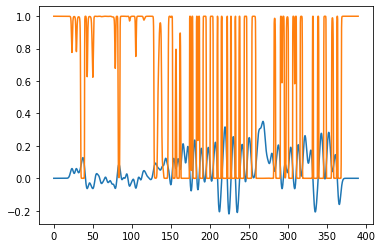

In [275]:
plt.plot(x,y1)
plt.plot(x,score(y1))

IndexError: index 2 is out of bounds for axis 0 with size 2

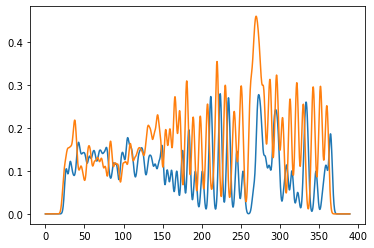

In [276]:
plt.plot(x,y.T)
mn, mx, th = active_index_range(y[0,:],y[2,:],0.02)
plt.plot([x[mn], x[mx]], [th]*2, 'b-')
plt.plot([x[mn], x[mx]], [th]*2, 'bo')

In [39]:
x[:10]

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25])

In [40]:
x[-10:]

array([387.5 , 387.75, 388.  , 388.25, 388.5 , 388.75, 389.  , 389.25,
       389.5 , 389.75])

In [63]:
active_index_range(y[0,:],y[1,:])

93 1461
94 1460


(94, 1460)

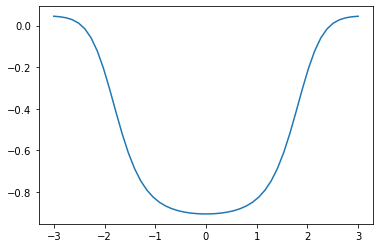

In [126]:
a = 1

s = 3
x = np.linspace(-3, 3,50)
plt.plot(x, (expit(a*x**2-s)-expit(s)))
#plt.ylim(0,1)

In [109]:
expit(0)

0.5

[0.0002 1.    ]
[0.00005 1.     ]
[0.00001 1.     ]
[0. 1.]
[0. 1.]
[0. 1.]


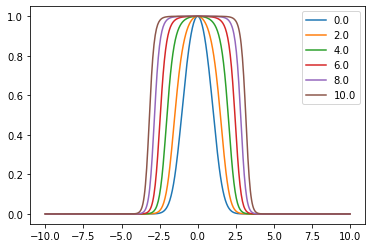

In [153]:
r = np.linspace(0,10,6)
for s in r:
    x = np.linspace(-10,10,500)
    #f = (expit(a*x**2-s)-expit(-s))
    f = expit(a*x**2-s)
    minf, maxf = expit(-s),1
    f = (f-minf)/(maxf-minf)
    plt.plot(x,1-f)
    print(
        np.array2string(np.array([f.min(), f.max()]), precision=5, suppress_small=True)
    )
plt.legend([str(d) for d in r])

In [123]:
expit(a*x**2-2).min()

0.1195970460921999

In [124]:
expit(a*x**2-8).min()

0.0003366091046778883

In [154]:
a

1

[0.00001 1.     ]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


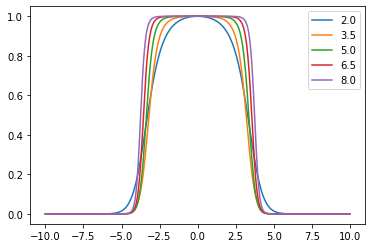

In [220]:
s = 3
a = 0.65 #r = np.linspace(0.2,0.8,5)
r = np.linspace(2,8,5)
for s in r:
    x = np.linspace(-10,10,500)
    #f = (expit(a*x**2-s)-expit(-s))
    f = expit((a*x)**2*np.log(s)-s/a)
    minf, maxf = expit(-s/a),1
    f = (f-minf)/(maxf-minf)
    plt.plot(x,1-f)
    print(
        np.array2string(np.array([f.min(), f.max()]), precision=5, suppress_small=True)
    )
plt.legend([str(d) for d in r])

[0.      0.99965]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


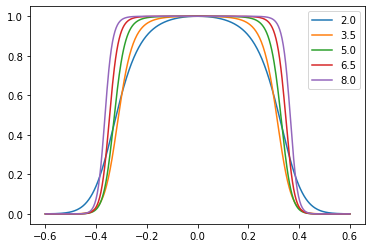

In [237]:
s = 3
a = 0.15#r = np.linspace(0.2,0.8,5)
k = 0.65
r = np.linspace(2,8,5)
for s in r:
    x = np.linspace(-4*a,4*a,500)
    #f = (expit(a*x**2-s)-expit(-s))
    f = expit((x/a)**2*np.log(s)-s/k)
    minf, maxf = expit(-s/k),1
    f = (f-minf)/(maxf-minf)
    plt.plot(x,1-f)
    print(
        np.array2string(np.array([f.min(), f.max()]), precision=5, suppress_small=True)
    )
plt.legend([str(d) for d in r])

[0. 1.]


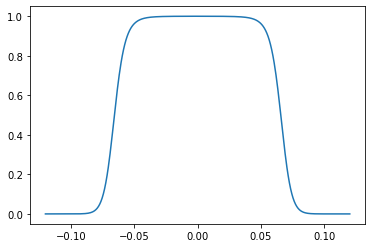

In [240]:
s = 5
a = 0.03#r = np.linspace(0.2,0.8,5)
k = 0.65
r = np.linspace(2,8,5)
x = np.linspace(-4*a,4*a,500)
#f = (expit(a*x**2-s)-expit(-s))
f = expit((x/a)**2*np.log(s)-s/k)
minf, maxf = expit(-s/k),1
f = (f-minf)/(maxf-minf)
plt.plot(x,1-f)
print(
    np.array2string(np.array([f.min(), f.max()]), precision=5, suppress_small=True)
)
#plt.legend([str(d) for d in r])

[0.00003 1.     ]
[0.00004 1.     ]
[0.00005 1.     ]
[0.00007 1.     ]
[0.00008 1.     ]


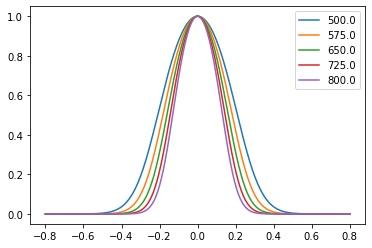

In [204]:
s = 1.0001
a = 0.65 #r = np.linspace(0.2,0.8,5)
r = np.linspace(500,800,5)
for a in r:
    x = np.linspace(-0.8,0.8,500)
    #f = (expit(a*x**2-s)-expit(-s))
    f = expit((a*x)**2*np.log(s)-s/a)
    minf, maxf = expit(-s/a),1
    f = (f-minf)/(maxf-minf)
    plt.plot(x,1-f)
    print(
        np.array2string(np.array([f.min(), f.max()]), precision=5, suppress_small=True)
    )
plt.legend([str(d) for d in r])

In [ ]:
s = 5
a = 0.03#r = np.linspace(0.2,0.8,5)
k = 0.65
r = np.linspace(2,8,5)
x = np.linspace(-4*a,4*a,500)
#f = (expit(a*x**2-s)-expit(-s))
f = expit((x/a)**2*np.log(s)-s/k)
minf, maxf = expit(-s/k),1
f = (f-minf)/(maxf-minf)
plt.plot(x,1-f)
print(
    np.array2string(np.array([f.min(), f.max()]), precision=5, suppress_small=True)
)

(1560,) (2, 1560)


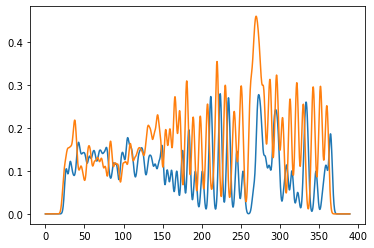

In [268]:
x = drumming_arr[0,0,:]
y = drumming_arr[:2,1,:]
print(x.shape, y.shape)
plt.plot(x,y.T)

In [258]:
score(y)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

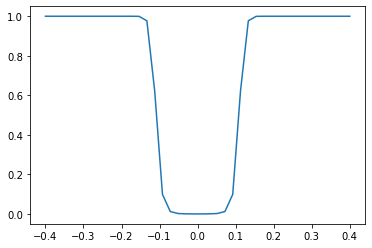

In [266]:
t = np.linspace(-0.4,0.4,40)
plt.plot(t, score(t))